In [34]:
import pandas as pd
import numpy as np
import seaborn as sns

In [35]:
ds = pd.read_csv("data.csv")
ds.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [36]:
ds.dtypes

Unnamed: 0             int64
key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [37]:
ds.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


## Preprocessing

### Handle null values

In [38]:
# check for null values in the data-frame
ds.isna().sum()

# dropoff_longitude and dropoff_latitude have a single null value
# remove those rows from the data-frame
ds.dropna(inplace=True)

### Feature Transformation

In [39]:
# remove date from the `key` column
# and keep only 'hour of the day'
ds["key"] = pd.to_datetime(ds["key"]).dt.strftime("%H").astype('float32')

# rename `key` to `time`
ds = ds.rename(columns={"key": "time"})

# `key` and `pickup_datetime` are same
# remove `pickup_datetime`
ds.drop(["pickup_datetime"], axis=1, inplace=True)

In [40]:
# drop `Unnamed: 0`
ds.drop(["Unnamed: 0"], axis=1, inplace=True)

In [41]:
import math

# add distance between pickup location and dropoff location
# in the ds

def euclidean_distance(lat1, lon1, lat2, lon2):
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    distance = math.sqrt(dlat**2 + dlon**2)
    return distance

ds['distance'] = ds.apply(
    lambda row: euclidean_distance(
        row['pickup_latitude'], 
        row['pickup_longitude'], 
        row['dropoff_latitude'], 
        row['dropoff_longitude']
    ), axis=1
)

## Analysis

### Outlier Analysis

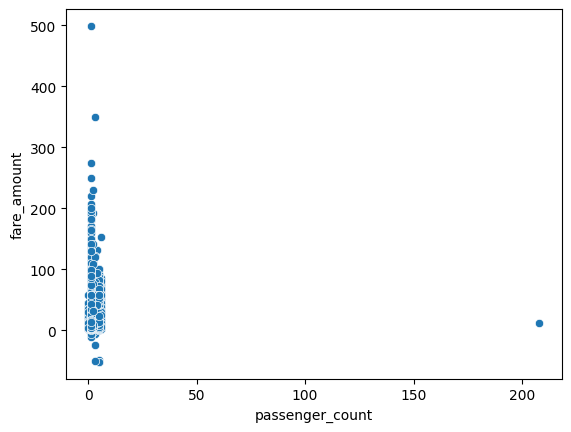

In [42]:
# remove outlier(s) where passenger_count > 100
sns.scatterplot(ds, y="fare_amount", x="passenger_count")
ds = ds[ds["passenger_count"] < 150]

In [43]:
# remove outliers from pickup/dropoff locations
def remove_outliers(feature):
    global ds
    q3 , q1 = np.percentile( ds[feature] , [ 75 , 25 ] )
    iqr = q3 - q1
    ds = ds[ (ds[feature] >= q1 - 1.5 * iqr) & (ds[feature] <= q3 + 1.5 * iqr) ]
    
remove_outliers("pickup_latitude")
remove_outliers("pickup_longitude")
remove_outliers("dropoff_latitude")
remove_outliers("dropoff_longitude")

### Correlation Analysis

In [44]:
ds.corr(method="pearson")

,time,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
time,1.000000,-0.000569,0.012361,0.034682,0.000191,0.024186,0.015100,-0.018899
fare_amount,-0.000569,1.000000,-0.042198,-0.072991,-0.009266,-0.093634,0.011859,0.702842
pickup_longitude,0.012361,-0.042198,1.000000,0.687198,0.389028,0.331470,-0.015273,-0.039332
pickup_latitude,0.034682,-0.072991,0.687198,1.000000,0.310747,0.475278,-0.012498,-0.073919
dropoff_longitude,0.000191,-0.009266,0.389028,0.310747,1.000000,0.636547,-0.012700,0.044977
dropoff_latitude,0.024186,-0.093634,0.331470,0.475278,0.636547,1.000000,-0.007887,-0.045410
passenger_count,0.015100,0.011859,-0.015273,-0.012498,-0.012700,-0.007887,1.000000,0.003703
distance,-0.018899,0.702842,-0.039332,-0.073919,0.044977,-0.045410,0.003703,1.000000


## Model Fitting

### Linear Regression

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# train-test split
X = ds.drop('fare_amount', axis=1)
y = ds['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standardize the splits
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [46]:
from sklearn.linear_model import LinearRegression

# linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model.predict(X_test_scaled)

In [47]:
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("RMSE: ", root_mean_squared_error(y_test, y_pred))

R2 score:  0.5280774655910482
RMSE:  3.3117630216159206


### Random Forest Regression

In [48]:
from sklearn.ensemble import RandomForestRegressor

# random forest regression model
# takes more time to train (comeback after 2 mins)
model = RandomForestRegressor()
model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model.predict(X_test_scaled)

In [49]:
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("RMSE: ", root_mean_squared_error(y_test, y_pred))

R2 score:  0.5371153451076254
RMSE:  3.27989761261114
